In [2]:
from time import time
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.naive_bayes import GaussianNB
import pandas as pd
from scikeras.wrappers import KerasClassifier

C:\Users\Niklas\AppData\Local\Temp\ipykernel_14304\3496188416.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
import datetime

import keras.utils
import pandas as pd
from keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import textwrap
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder


def split_match_data(match_data, list_of_features: list[str], target_variable: str, test_size=0.3, random_state=42):
    X = match_data[list_of_features]
    y = match_data[target_variable]
    le = LabelEncoder()
    y = le.fit_transform(y)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    return X_train, X_test, y_train, y_test


def get_model_metrics(models, X_train, X_test, y_train, y_test, epochs=300):
    batch_size = 64
    model_metrics = {}
    for model in models:
        model_name = model.__class__.__name__
        if model_name == 'KerasClassifier':
            log_dir = "./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
            tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
            model_name = model.model.name
            print(f"Training {model_name}")
            early_stopping = EarlyStopping(monitor="val_loss",
                                           mode="min", patience=5,
                                           restore_best_weights=True)
            model.fit(
                X_train, y_train, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs
                ,
                callbacks=[early_stopping, tensorboard_callback]
            )
            keras.utils.plot_model(model.model, show_shapes=True, show_layer_names=True,
                                   to_file=f"stat/{model_name}_flowchart.png")
        else:
            model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        model_score = model.score(X_test, y_test)
        accuracy = accuracy_score(y_test, predictions)
        conf_matrix = confusion_matrix(y_test, predictions)
        precision = precision_score(y_test, predictions, average='weighted', zero_division=0)
        recall = recall_score(y_test, predictions, average='weighted')
        f1 = f1_score(y_test, predictions, average='weighted')
        y_true = y_test
        y_pred = predictions
        # plot_confusionMatrix(y_true, y_pred)

        model_metrics[model_name] = {
            'Score': model_score,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-score': f1
        }

    return model_metrics


def get_scores(modelMetrics):
    for model_name, metrics in modelMetrics.items():
        print(f"{model_name} Score is {str(metrics['Score'])[:4]}")


def wrap_labels(ax, width, break_long_words=True):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                                    break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)


def plot_scores(model_metrics):
    # Define the label locations and the width of the bars
    x = np.arange(len(model_metrics))
    width = 0.15

    fig, ax = plt.subplots(figsize=(15, 8))

    # Create a color palette
    colours = sns.color_palette('pastel')

    # Specify the order of metrics
    metrics_order = ['Score', 'Recall', 'Accuracy', 'F1-score', 'Precision']

    # Create a bar for each metric in the specified order
    for metric_id, metric in enumerate(metrics_order):
        values = [metrics[metric] for metrics in model_metrics.values()]
        rects = ax.bar(x + width * metric_id, values, width, label=metric, color=colours[metric_id])

    # find min and max values for y axis and limit the y axis
    min_y = min([min([metrics[metric] for metrics in model_metrics.values()]) for metric in metrics_order])
    max_y = max([max([metrics[metric] for metrics in model_metrics.values()]) for metric in metrics_order])
    ax.set_ylim([min_y - 0.05, max_y + 0.05])

    # Add labels, title, legend, etc.
    ax.set_ylabel('Metrics')
    ax.set_title('Model Metrics by Model')
    ax.set_xticks(x + width * 2)
    ax.set_xticklabels(model_metrics.keys())
    ax.legend()

    wrap_labels(ax, 10)

    plt.show()
    plt.savefig('stat/model_metrics.png')


def plot_confusionMatrix(y_true, y_pred):
    cn = confusion_matrix(y_true=y_true, y_pred=y_pred)

    fig, ax = plt.subplots(figsize=(5, 5))
    sns.heatmap(cn, annot=True, linewidths=1.5)
    plt.show()
    return cn


In [4]:
import numpy as np
from sklearn.datasets import make_classification
from tensorflow import keras


def get_LSTM(input_dim=29, units=64, output_size=3, allow_cudnn_kernel=True):
    model = keras.models.Sequential(name="lstm_model")
    if allow_cudnn_kernel:
        model.add(keras.layers.LSTM(units, input_shape=(input_dim, 1), return_sequences=False))
    else:
        model.add(keras.layers.RNN(keras.layers.LSTMCell(units), input_shape=(input_dim, 1)))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(output_size, activation='softmax'))

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        metrics=['accuracy']
    )
    print(model.summary())
    return model


def get_Dense(input_dim=29, output_size=3):
    model = keras.models.Sequential(name="dense_model")
    model.add(keras.layers.Dense(64, activation='relu', input_shape=(input_dim,)))
    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.Dense(output_size, activation='softmax'))

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    print(model.summary())
    return model


def get_CNN(input_dim=29, output_size=3):
    model = keras.models.Sequential(name="cnn_model")
    model.add(keras.layers.Conv1D(32, 3, activation='relu', input_shape=(input_dim, 1)))
    model.add(keras.layers.MaxPooling1D(2))
    model.add(keras.layers.Conv1D(64, 3, activation='relu'))
    model.add(keras.layers.MaxPooling1D(2))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(output_size, activation='softmax'))

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    print(model.summary())
    return model


In [5]:
models = [
    RandomForestClassifier(n_estimators=100),
    GradientBoostingClassifier(),
    LogisticRegression(max_iter=1000),
    SVC(),
    LinearSVC(),
    NuSVC(),
    KNeighborsClassifier(n_neighbors=22),
    KerasClassifier(
        get_CNN(),
        loss="sparse_categorical_crossentropy",
    ),
    KerasClassifier(
        get_Dense(),
        loss="sparse_categorical_crossentropy"
    ),
    KerasClassifier(
        get_LSTM(),
        loss="sparse_categorical_crossentropy",
    ),

    GaussianNB(),
]

# list_of_features = [
#    'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'HTGS', 'ATGS', 'HTGC', 'ATGC', 'HTP', 'ATP',
#    'HM1', 'AM1', 'HM2', 'AM2', 'HM3', 'AM3', 'HM4', 'AM4', 'HM5', 'AM5', 'MW', 'HomeTeamLP',
#    'AwayTeamLP', 'HTFormPtsStr', 'ATFormPtsStr', 'HTFormPts', 'ATFormPts', 'HTWinStreak3',
#    'HTWinStreak5', 'HTLossStreak3', 'HTLossStreak5', 'ATWinStreak3', 'ATWinStreak5',
#    'ATLossStreak3', 'ATLossStreak5', 'HTGD', 'ATGD', 'DiffPts', 'DiffFormPts', 'DiffLP'
# ]

list_of_features = [
    'HTP', 'ATP',
    'HM1', 'AM1', 'HM2', 'AM2', 'HM3', 'AM3', 'HM4', 'AM4', 'HM5', 'AM5', 'HomeTeamLP',
    'AwayTeamLP', 'HTFormPts', 'ATFormPts', 'HTWinStreak3',
    'HTWinStreak5', 'HTLossStreak3', 'HTLossStreak5', 'ATWinStreak3', 'ATWinStreak5',
    'ATLossStreak3', 'ATLossStreak5', 'HTGD', 'ATGD', 'DiffPts', 'DiffFormPts', 'DiffLP'
]

target_variable = 'FTR'

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 27, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 13, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 5, 64)            0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 320)               0         
                                                                 
 dense (Dense)               (None, 64)                20

In [13]:
%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Launching TensorBoard...

C:\Users\Niklas\PycharmProjects\fb-predictions-pl\venv\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\Niklas\PycharmProjects\fb-predictions-pl\venv\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Training cnn_model
Epoch 1/500
86/86 [==============================] - 1s 7ms/step - loss: 0.3723 - accuracy: 0.8447 - val_loss: 1.9446 - val_accuracy: 0.5699
Epoch 2/500
86/86 [==============================] - 0s 6ms/step - loss: 0.3601 - accuracy: 0.8518 - val_loss: 1.9441 - val_accuracy: 0.5567
Epoch 3/500
86/86 [==============================] - 1s 6ms/step - loss: 0.3664 - accuracy: 0.8489 - val_loss: 1.9331 - val_accuracy: 0.5597
Epoch 4/500
86/86 [==============================] - 1s 6ms/step - loss: 0.3570 - accuracy: 0.8504 - val_loss: 1.9294 - val_accuracy: 0.5533
Epoch 5/500
86/86 [==============================] - 1s 7ms/step - loss: 0.3506 - accuracy: 0.8555 - val_loss: 1.9860 - val_accuracy: 0.5567
Epoch 6/500
86/86 [==============================] - 1s 8ms/step - loss: 0.3619 - accuracy: 0.8482 - val_loss: 1.9490 - val_accuracy: 0.5580
Epoch 7/500
86/86 [==============================] - 1s 7ms/step - loss: 0.3564 - accuracy: 0.8531 - val_loss: 1.9539 - val_accuracy: 0

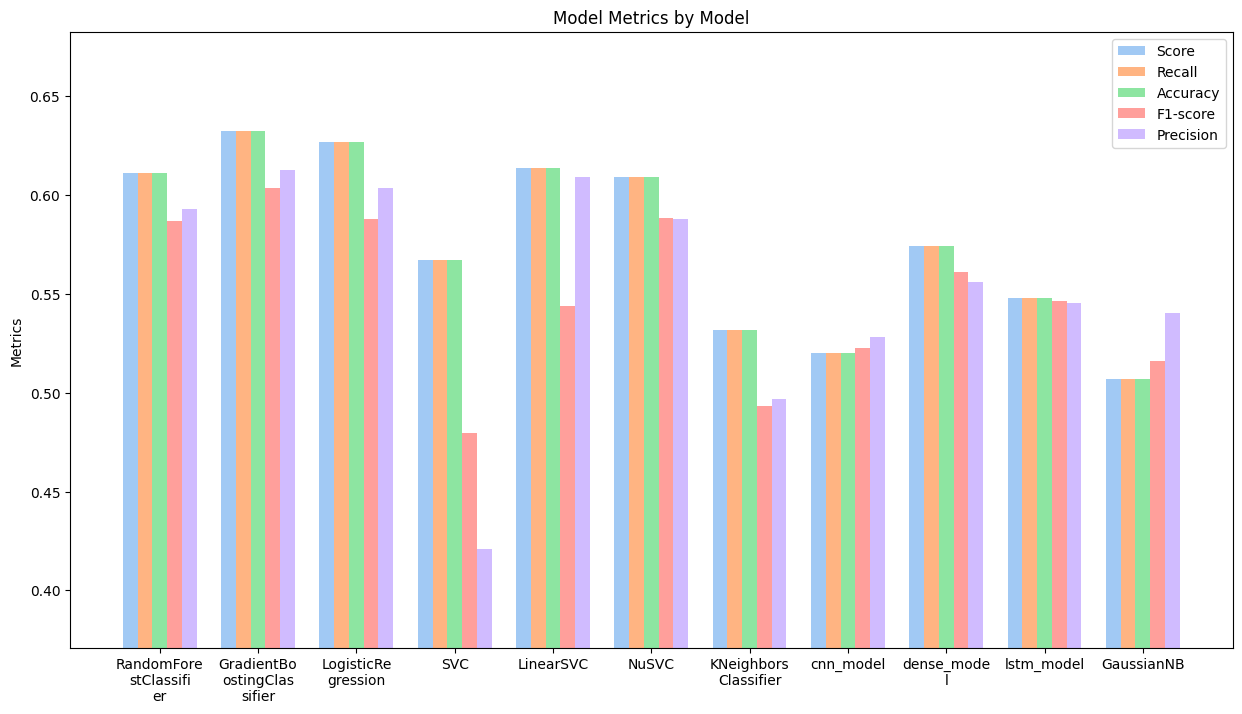

Time taken: 2111.0916640758514 seconds


<Figure size 640x480 with 0 Axes>

In [12]:
start = time()
match_data = pd.read_csv("data/all_stats.csv")
X_train, X_test, y_train, y_test = split_match_data(match_data, list_of_features, target_variable)
metrics_df = get_model_metrics(models, X_train, X_test, y_train, y_test,500)
get_scores(metrics_df)
plot_scores(metrics_df)
end = time()
print(f"Time taken: {end - start} seconds")

In [11]:
!dir

 Volume in drive C is Windows
 Volume Serial Number is 6080-5FF0

 Directory of C:\Users\Niklas\PycharmProjects\fb-predictions-pl

04/03/2024  15:45    <DIR>          .
20/02/2024  15:53    <DIR>          ..
04/03/2024  15:43    <DIR>          .idea
22/02/2024  14:57             1,265 createLeagueTable.csv.py
22/02/2024  20:00    <DIR>          data
04/03/2024  11:58            14,644 dataManipulation.py
04/03/2024  15:44    <DIR>          logs
04/03/2024  14:15             2,385 main.py
04/03/2024  11:41             2,006 models.py
04/03/2024  11:57             4,931 model_evaluation.py
22/02/2024  14:57               862 replacenames.py
27/02/2024  10:51               143 requirements.txt
04/03/2024  14:44    <DIR>          stat
04/03/2024  15:45           224,392 stats.ipynb
04/03/2024  14:12    <DIR>          venv
04/03/2024  11:42    <DIR>          __pycache__
               8 File(s)        250,628 bytes
               8 Dir(s)  41,206,796,288 bytes free
